<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [311]:
%matplotlib inline

# general libraries
import sys
import math
import operator
import itertools
import pydotplus
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import argmax
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [312]:
global_info = {}

In [313]:
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [314]:
def plot_classification_report(y_test, y_pred_vals_u, model_classes, cmap, title):
    clf_report = classification_report(y_test,
                                   y_pred_vals_u,
                                   labels=np.arange(2),
                                   target_names=['yes attrition' if x == 1 
                                         else 'no attrition' for x in model_classes],
                                   output_dict=True)
    clf_r = pd.DataFrame(clf_report).iloc[:-1, :].T
    # clf_r.iloc[2, 0] = np.nan
    # clf_r.iloc[2, 1] = np.nan
    sns.heatmap(clf_r, annot=True, cmap=cmap, cbar=False)
    plt.title(title)
    plt.show()

In [315]:
def to_labels(pos_probs, threshold):
    # apply threshold to positive probabilities to create labels
    return (pos_probs >= threshold).astype('int')

In [738]:
def get_model_thresholds(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    # predict probabilities
    yhat = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [average_precision_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    print( 'ModelThreshold=%.3f, AP=%.5f ' % (thresholds[ix], scores[ix]))
    return thresholds[ix]

In [547]:
def fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train,
                     X_test, y_test, models_u, min_impurity_decrease):
    y_pred_vals_u = []
    y_pred_trains_u = []
    roc_auc_models_u_val = []
    precision_recall_auc_models_u_val = []
    clf = None
    if type_flag2 == "validation" or type_flag2 == "test":
        models_u = []
        clf = DecisionTreeClassifier(criterion=criterion, 
                                     max_features=max_features,
                                     max_depth=max_depth,
                                     min_samples_split=min_samples_split, 
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight=class_weight)
        clf = clf.fit(X_train, y_train)
        models_u.append(clf)
    elif type_flag2 == "threshold test":
        models_u = []
        clf = DecisionTreeClassifier(criterion=criterion, 
                                     max_features=max_features,
                                     max_depth=max_depth,
                                     min_samples_split=min_samples_split, 
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight=class_weight,
                                     min_impurity_decrease=int(min_impurity_decrease))
        clf = clf.fit(X_train, y_train)
        models_u.append(clf)
    else:
        print("Wrong type_flag=%s" % type_flag2)
        
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr)


    fpr, tpr, thresholds = roc_curve(y_train, y_pred_trains_u[0])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_train, y_pred_trains_u[0], average="weighted")
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_trains_u[0]))
    print('Train Precision %s' % precision_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train Recall %s' % recall_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train F1-score %s' % f1_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train F2-score %s' % fbeta_score(y_train, y_pred_trains_u[0], average="weighted", beta=2))
    print("Train roc_auc: {}".format(roc_auc))
    print(classification_report(y_train, y_pred_trains_u[0]))
    plot_classification_report(y_train, y_pred_trains_u[0], models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag1))
    cm = confusion_matrix(y_train, y_pred_trains_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, False, "Model %d\'s %s confusion matrix"
                          % (model_name, type_flag1), cmap)
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred_vals_u[0], average="weighted")
    roc_auc_models_u_val.append(roc_auc)
    print("Validation roc_auc: {}".format(roc_auc))

    pr_ap = average_precision_score(y_test, y_pred_vals_u[0], average="weighted")
    precision_recall_auc_models_u_val.append(pr_ap)
    print("Validation precision_recall_ap: {}".format(pr_ap))

    print('\nTest Accuracy %s' % accuracy_score(y_test, y_pred_vals_u[0]))
    print('Validation Precision %s' % precision_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation Recall %s' % recall_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation F1-score %s' % f1_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation F2-score %s' % fbeta_score(y_test, y_pred_vals_u[0], average="weighted", beta=2))
    print(classification_report(y_test, y_pred_vals_u[0]))
    plot_classification_report(y_test, y_pred_vals_u[0], models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag2))
    cm = confusion_matrix(y_test, y_pred_vals_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, False, "Model %d\'s %s confusion matrix" 
                          % (model_name, type_flag2), cmap)
    plt.show()

    if type_flag2 == "validation":
        # plot current model's features importance
        x = []
        y = []
        for i in range(len(clf.feature_importances_)):
            if clf.feature_importances_[i] > 0:
                x.append(list(X.columns)[i])
                y.append(clf.feature_importances_[i])
        plt.bar(x, y, color=color)
        plt.xticks(rotation=90)
        plt.ylabel("Score")
        plt.xlabel("Features")
        plt.title("Features importance for model %d" % (model_name))
        plt.show()
        
    return models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val

In [808]:
def draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,
                                       y_pred_trains_u, y_pred_vals_u):
    cm = confusion_matrix(y_train, y_pred_trains_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, True, 
                          "Model %d\'s %s normalized confusion matrix" % (model_name, type_flag2), cmap)
    plt.show()

    cm = confusion_matrix(y_test, y_pred_vals_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, True, 
                          "Model %d\'s %s normalized confusion matrix"  % (model_name, type_flag2), cmap)
    plt.show()

In [425]:
def draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val):
    
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_vals_u[0])
    plt.plot(fpr, tpr, color=color, label='%0.4f' % (roc_auc_models_u_val[0]))

    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    plt.title("Model %d's %s ROC-curve" % (model_name, type_flag))
    plt.show()
    
    # draw_pr_ap_curve
    plt.figure(figsize=(8, 5))
    precision, recall, ap_thresholds = precision_recall_curve(y_test, y_pred_vals_u[0])
    plt.plot(precision, recall, color=color, label='%0.4f' %\
             (precision_recall_auc_models_u_val[0]))
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='%0.4f' % no_skill) 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", title="AP", frameon=True)
    plt.title("Model %d's %s PR-curve" % (model_name, type_flag))
    plt.show()

    if type_flag == "validation":
        global_info[str(model_name)] = {}

    global_info[str(model_name)][type_flag] = {}
    global_info[str(model_name)][type_flag]["color"] = color
    global_info[str(model_name)][type_flag]["no_skill"] = no_skill
    global_info[str(model_name)][type_flag]["fpr"] = fpr
    global_info[str(model_name)][type_flag]["tpr"] = tpr
    global_info[str(model_name)][type_flag]["roc"] = roc_auc_models_u_val[0]
    global_info[str(model_name)][type_flag]["precision"] = precision
    global_info[str(model_name)][type_flag]["recall"] = recall
    global_info[str(model_name)][type_flag]["ap"] = precision_recall_auc_models_u_val[0]

In [430]:
def draw_multiple_roc_and_ap_curves(type_flag):
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    for model_name in global_info.keys():
        color = global_info[str(model_name)][type_flag]["color"]
        fpr = global_info[str(model_name)][type_flag]["fpr"]
        tpr = global_info[str(model_name)][type_flag]["tpr"]
        roc_auc = global_info[str(model_name)][type_flag]["roc"] 
        plt.plot(fpr, tpr, color=color, label='%0.4f' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    plt.title("Models' %s ROC-curve" % type_flag)
    plt.show()
    
     # draw_pr_ap_curve
    no_skill = -1
    plt.figure(figsize=(8, 5))
    for model_name in global_info.keys():
        color = global_info[str(model_name)][type_flag]["color"]
        no_skill = global_info[str(model_name)][type_flag]["no_skill"]
        precision = global_info[str(model_name)][type_flag]["precision"]
        recall = global_info[str(model_name)][type_flag]["recall"]
        ap = global_info[str(model_name)][type_flag]["ap"] 
        plt.plot(precision, recall, color=color, label='%0.4f' % (ap))
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='%0.4f' % no_skill) 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", title="AP", frameon=True)
    plt.title("Models' %s PR-curve" % type_flag)
    plt.show()

<h1> Numerical_Disctetized_HISTOGRAM_Recall_no_satisfactions </h1>

In [320]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Discretized_HISTOGRAM_Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_HISTOGRAM_Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [321]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [322]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [323]:
del df_cleaned["EnvironmentSatisfaction"]
del df_cleaned["JobInvolvement"]
del df_cleaned["JobSatisfaction"]
del df_cleaned["RelationshipSatisfaction"]
del df_cleaned["WorkLifeBalance"]
df_cleaned.shape

(883, 19)

In [324]:
del df_ts["EnvironmentSatisfaction"]
del df_ts["JobInvolvement"]
del df_ts["JobSatisfaction"]
del df_ts["RelationshipSatisfaction"]
del df_ts["WorkLifeBalance"]
df_ts.shape

(219, 19)

In [325]:
criterion='entropy'
max_features='log2'
max_depth=11
min_samples_split=80
min_samples_leaf=5
class_weight='balanced'
model_name = 17
cmap = plt.cm.Greens
color = "green"

<h6> Train again model on Validation Set </h6>

In [326]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 18)
(883,)


In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [436]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7686084142394822
Train Precision 0.8483944968334338
Train Recall 0.7686084142394822
Train F1-score 0.7920742923506924
Train F2-score 0.7729804784209271
Train roc_auc: 0.7677176875102877
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       511
           1       0.41      0.77      0.53       107

    accuracy                           0.77       618
   macro avg       0.68      0.77      0.69       618
weighted avg       0.85      0.77      0.79       618



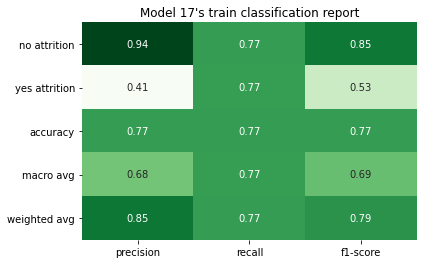

Confusion matrix, without normalization
[[393 118]
 [ 25  82]]


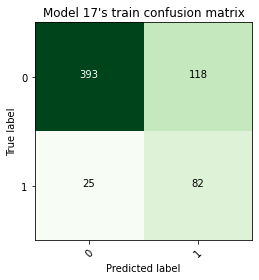

Validation roc_auc: 0.7319336906889021
Validation precision_recall_ap: 0.32791941446576395

Test Accuracy 0.769811320754717
Validation Precision 0.8303625519402316
Validation Recall 0.769811320754717
Validation F1-score 0.7900524379125391
Validation F2-score 0.7749374384779992
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       219
           1       0.40      0.67      0.50        46

    accuracy                           0.77       265
   macro avg       0.66      0.73      0.68       265
weighted avg       0.83      0.77      0.79       265



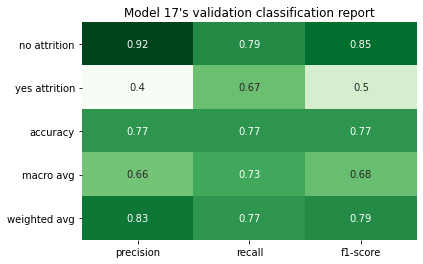

Confusion matrix, without normalization
[[173  46]
 [ 15  31]]


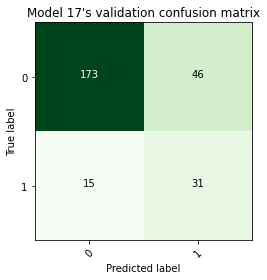

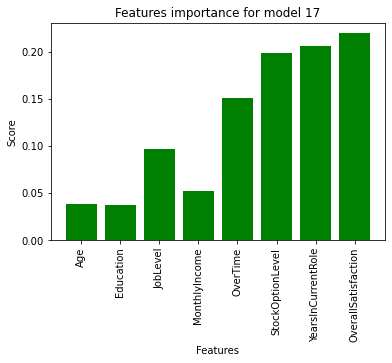

In [399]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

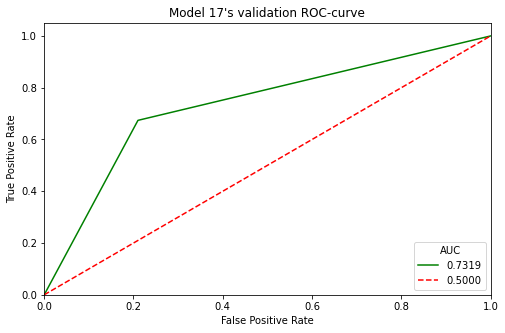

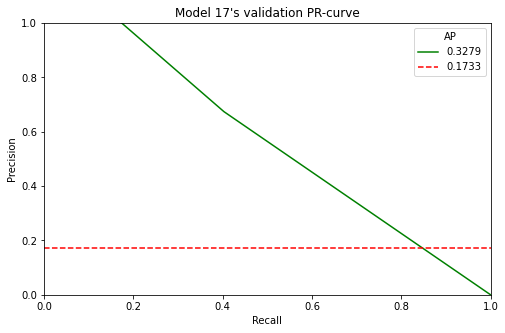

In [432]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.76908023 0.23091977]
 [0.23364486 0.76635514]]


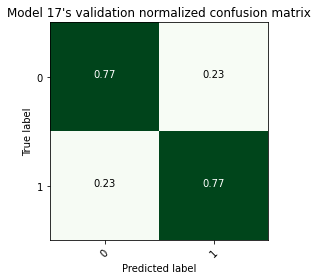

Normalized confusion matrix
[[0.78995434 0.21004566]
 [0.32608696 0.67391304]]


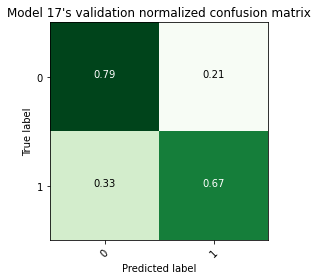

In [433]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

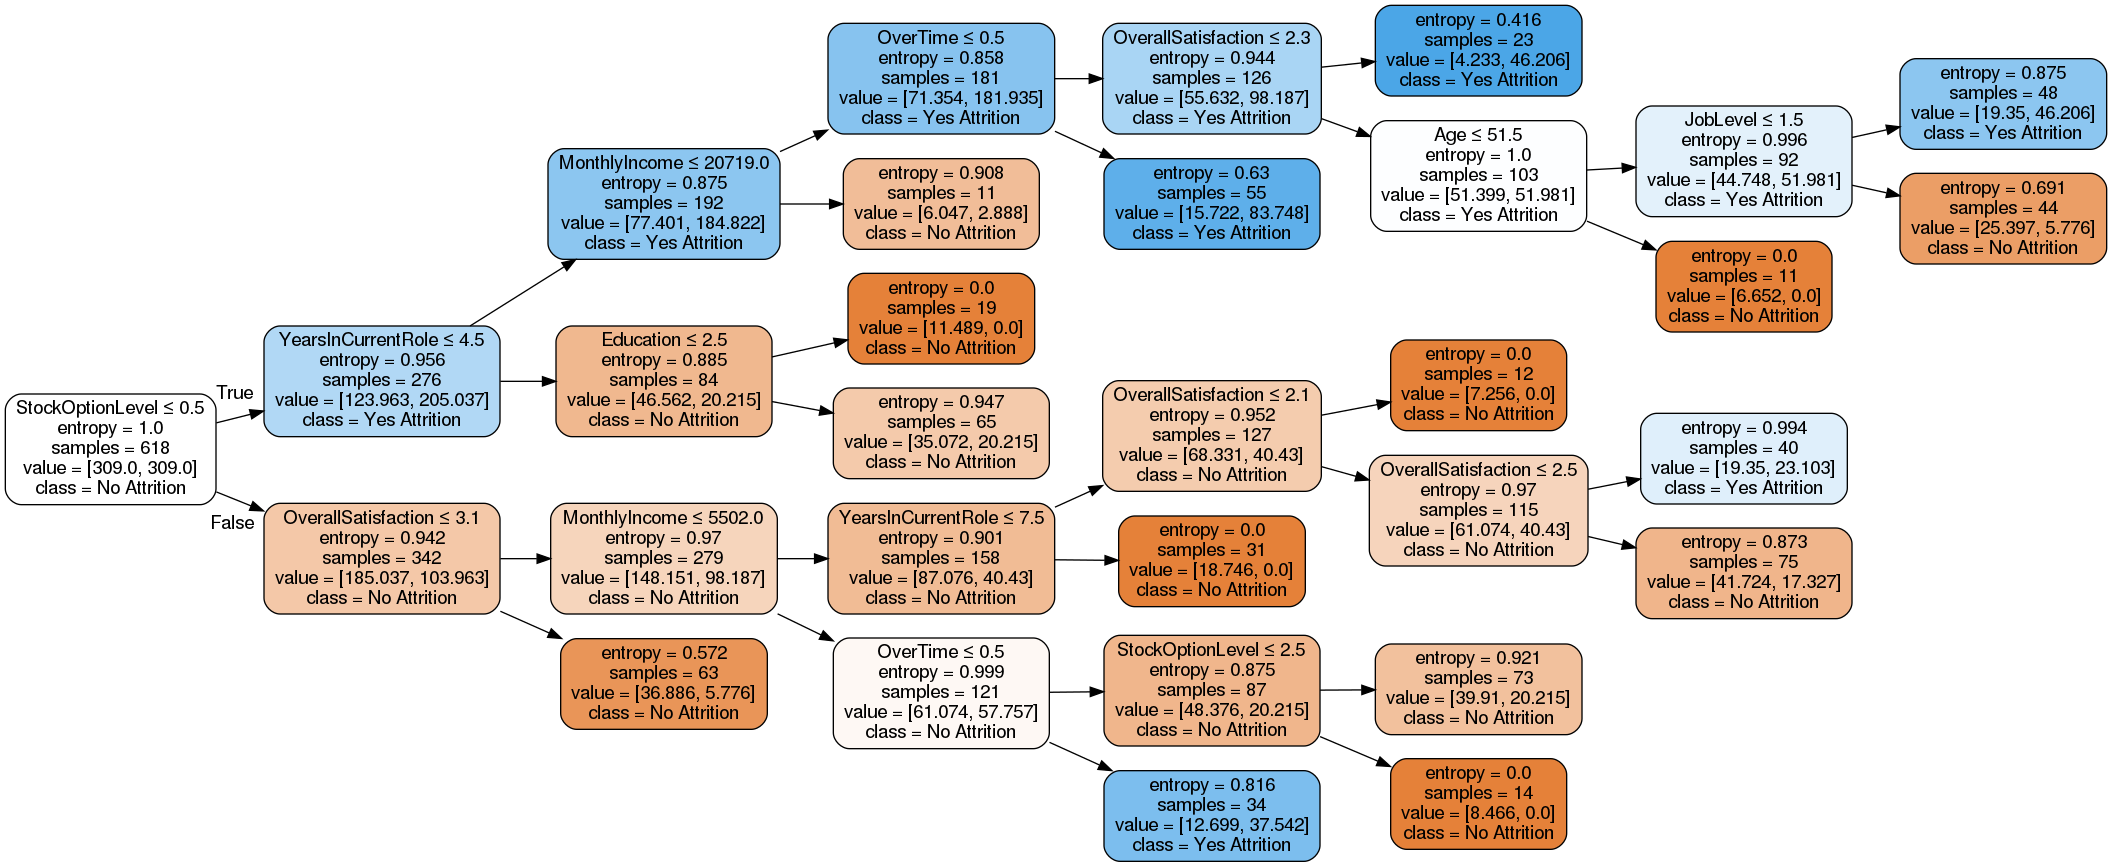

In [402]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

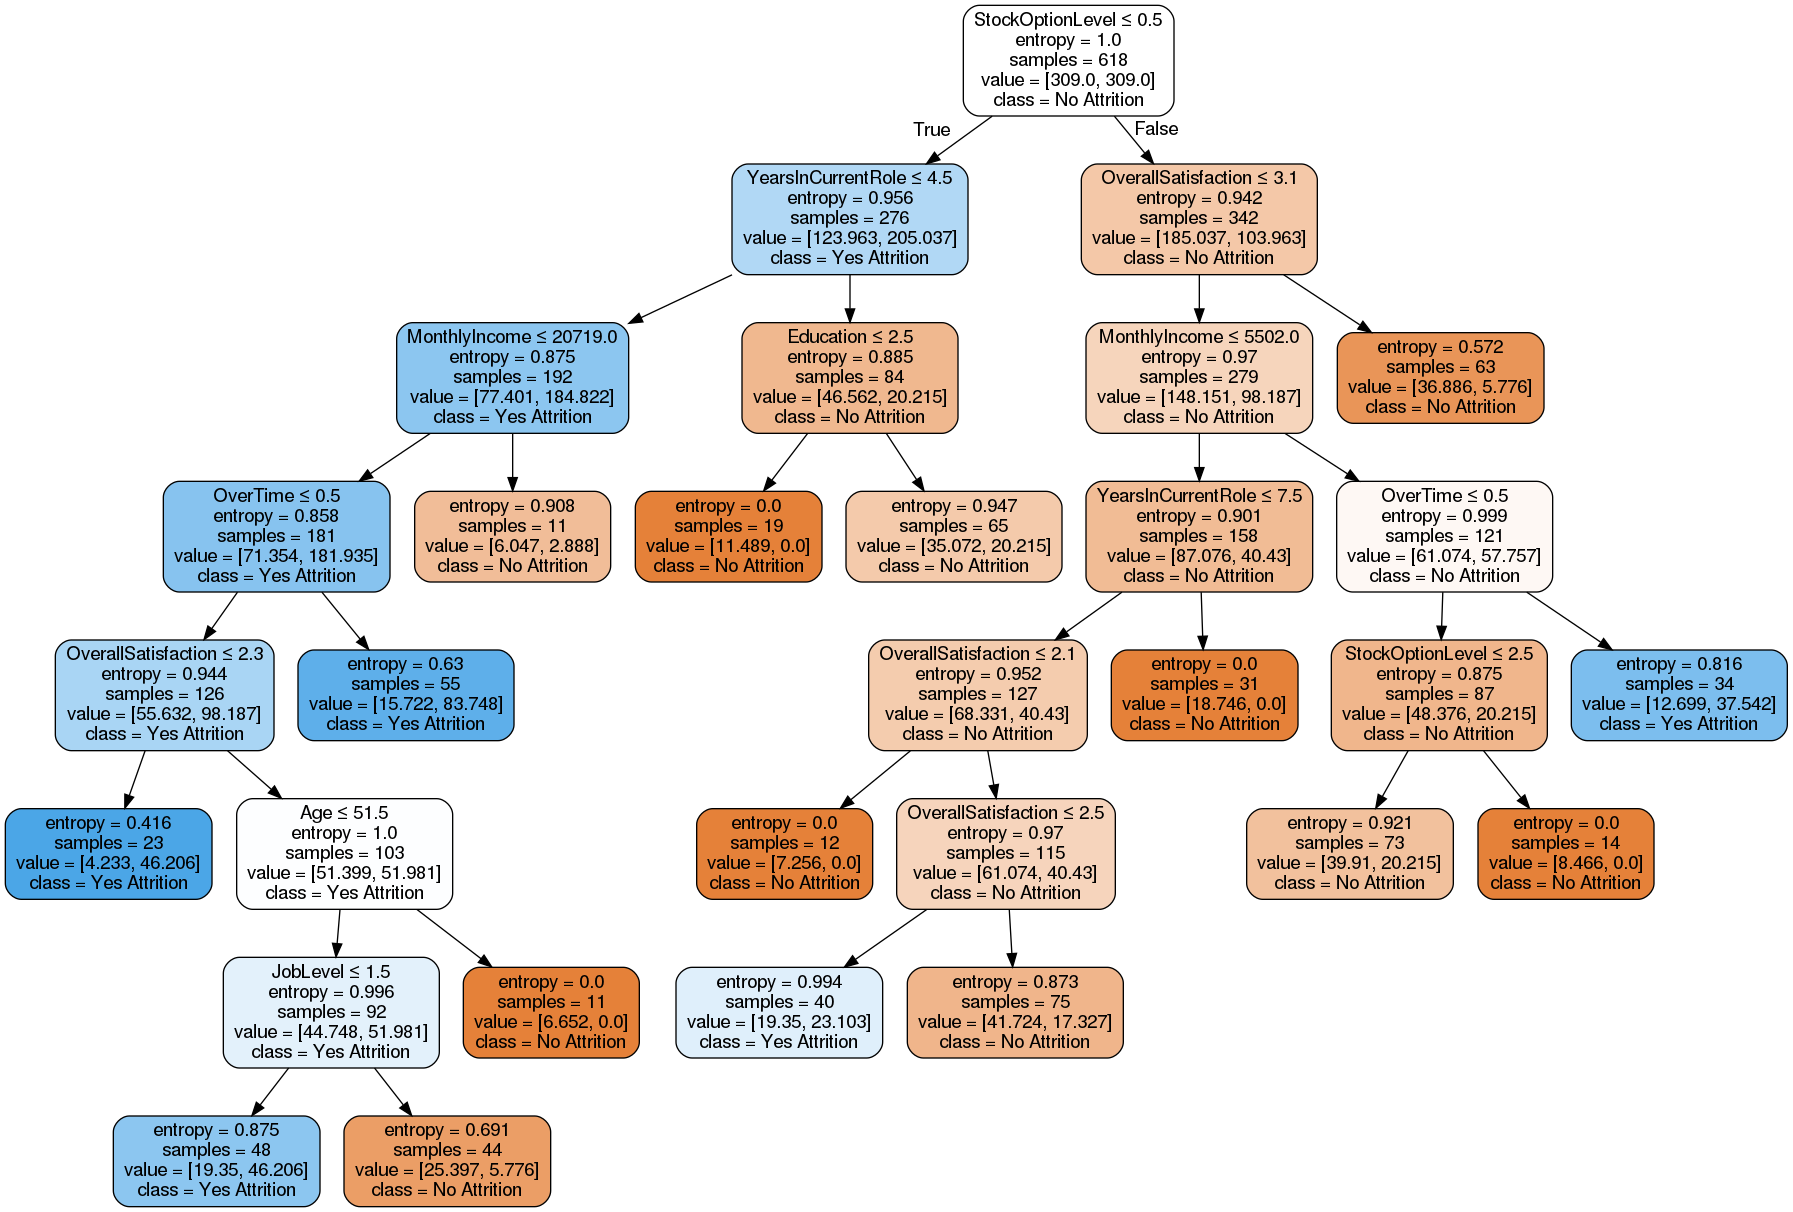

In [403]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [438]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 18)
(883,)


In [439]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 18)
(219,)


In [541]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.6976217440543602
Train Precision 0.8495986077436171
Train Recall 0.6976217440543602
Train F1-score 0.73405608414435
Train F2-score 0.7000961535800527
Train roc_auc: 0.7577133136359567
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       730
           1       0.35      0.85      0.49       153

    accuracy                           0.70       883
   macro avg       0.65      0.76      0.64       883
weighted avg       0.85      0.70      0.73       883



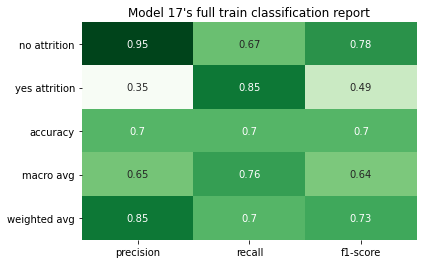

Confusion matrix, without normalization
[[486 244]
 [ 23 130]]


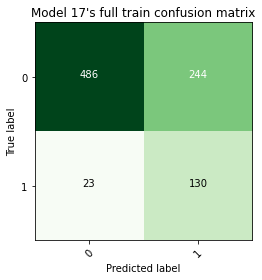

Validation roc_auc: 0.699523052464229
Validation precision_recall_ap: 0.27783068395477745

Test Accuracy 0.776255707762557
Validation Precision 0.8290911115835942
Validation Recall 0.776255707762557
Validation F1-score 0.7959209444841121
Validation F2-score 0.7821258465513933
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       185
           1       0.36      0.59      0.45        34

    accuracy                           0.78       219
   macro avg       0.64      0.70      0.65       219
weighted avg       0.83      0.78      0.80       219



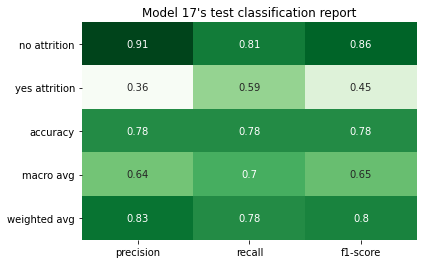

Confusion matrix, without normalization
[[150  35]
 [ 14  20]]


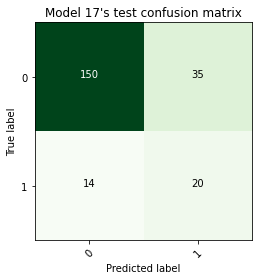

In [566]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

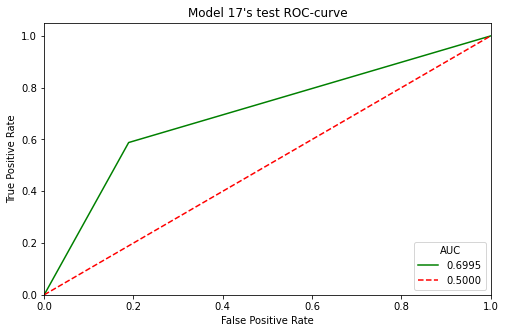

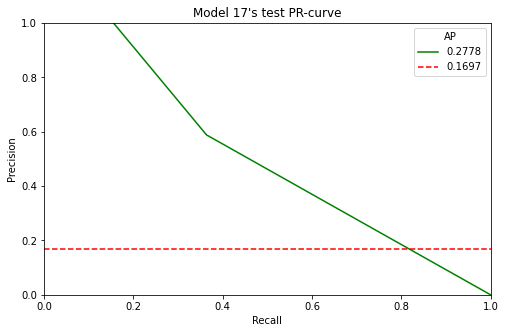

In [567]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.66575342 0.33424658]
 [0.1503268  0.8496732 ]]


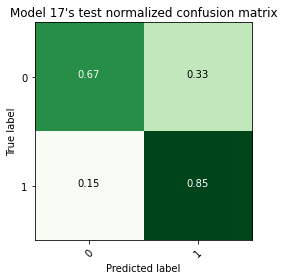

Normalized confusion matrix
[[0.81081081 0.18918919]
 [0.41176471 0.58823529]]


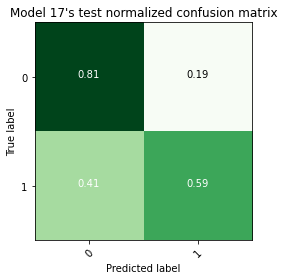

In [568]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [739]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.621, AP=0.20635 


Train Accuracy 0.7610419026047565
Train Precision 0.8444529323802231
Train Recall 0.7610419026047565
Train F1-score 0.7856190472209926
Train F2-score 0.7656446963055941
Train roc_auc: 0.7599068851284805
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       730
           1       0.40      0.76      0.52       153

    accuracy                           0.76       883
   macro avg       0.67      0.76      0.68       883
weighted avg       0.84      0.76      0.79       883



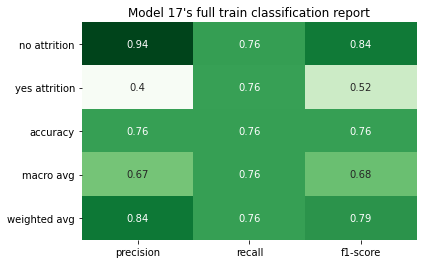

Confusion matrix, without normalization
[[556 174]
 [ 37 116]]


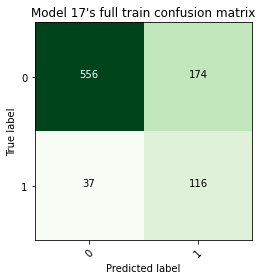

Validation roc_auc: 0.701033386327504
Validation precision_recall_ap: 0.28969413107708836

Test Accuracy 0.7990867579908676
Validation Precision 0.8321016582552271
Validation Recall 0.7990867579908676
Validation F1-score 0.8122873471308208
Validation F2-score 0.8034324810888994
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       185
           1       0.40      0.56      0.46        34

    accuracy                           0.80       219
   macro avg       0.65      0.70      0.67       219
weighted avg       0.83      0.80      0.81       219



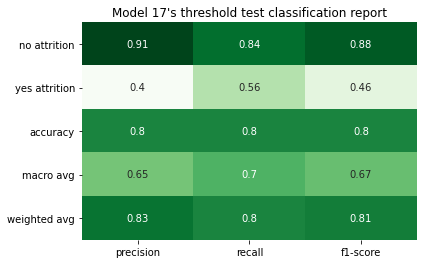

Confusion matrix, without normalization
[[156  29]
 [ 15  19]]


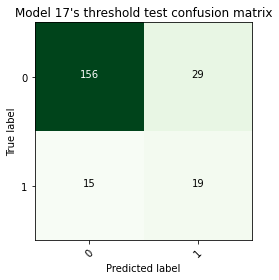

In [767]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

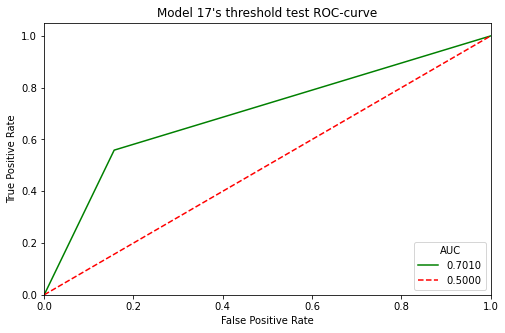

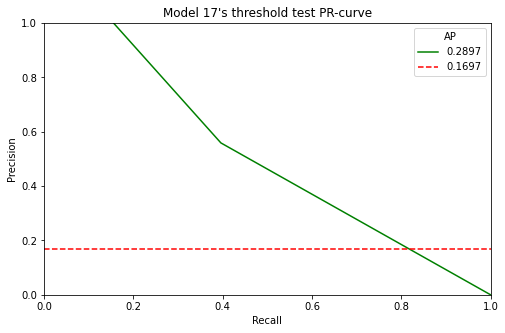

In [768]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.76164384 0.23835616]
 [0.24183007 0.75816993]]


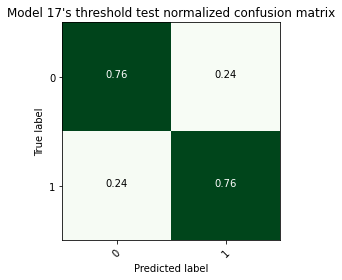

Normalized confusion matrix
[[0.84324324 0.15675676]
 [0.44117647 0.55882353]]


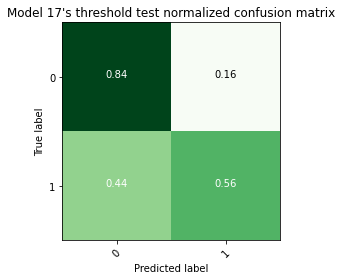

In [769]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h1> Numerical_Disctetized_HISTOGRAM_Recall </h1>

In [809]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Discretized_HISTOGRAM_Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_HISTOGRAM_Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [810]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [811]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [812]:
del df_cleaned["OverallSatisfaction"]
df_cleaned.shape

(883, 23)

In [813]:
del df_ts["OverallSatisfaction"]
df_ts.shape

(219, 23)

In [814]:
criterion='entropy'
max_features='auto'
max_depth=2
min_samples_split=30
min_samples_leaf=80
class_weight='balanced'
model_name = 76
cmap = plt.cm.Blues
color = "blue"

<h6> Train again model on Validation Set </h6>

In [815]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 22)
(883,)


In [816]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [817]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7184466019417476
Train Precision 0.7885949009155032
Train Recall 0.7184466019417476
Train F1-score 0.7440300498778711
Train F2-score 0.7259213613827652
Train roc_auc: 0.6487188397315141
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       511
           1       0.32      0.54      0.40       107

    accuracy                           0.72       618
   macro avg       0.60      0.65      0.61       618
weighted avg       0.79      0.72      0.74       618



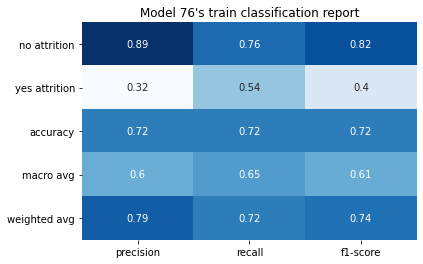

Confusion matrix, without normalization
[[386 125]
 [ 49  58]]


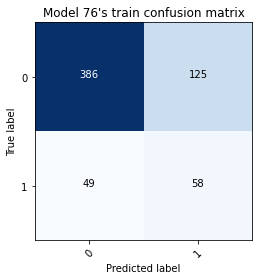

Validation roc_auc: 0.6593210244192971
Validation precision_recall_ap: 0.25916735028712057

Test Accuracy 0.720754716981132
Validation Precision 0.793488016318205
Validation Recall 0.720754716981132
Validation F1-score 0.7466802475395787
Validation F2-score 0.7280716219150947
              precision    recall  f1-score   support

           0       0.89      0.75      0.82       219
           1       0.33      0.57      0.41        46

    accuracy                           0.72       265
   macro avg       0.61      0.66      0.61       265
weighted avg       0.79      0.72      0.75       265



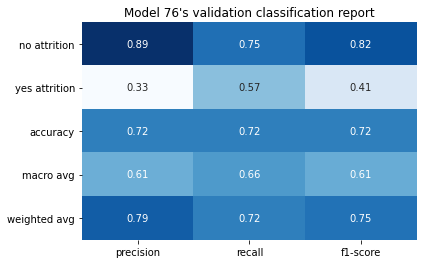

Confusion matrix, without normalization
[[165  54]
 [ 20  26]]


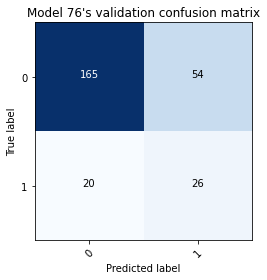

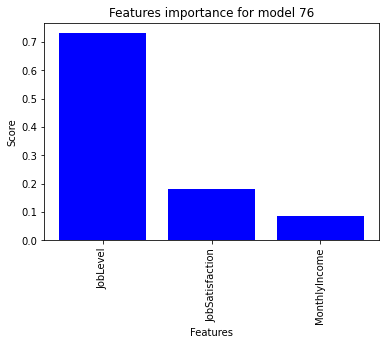

In [851]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

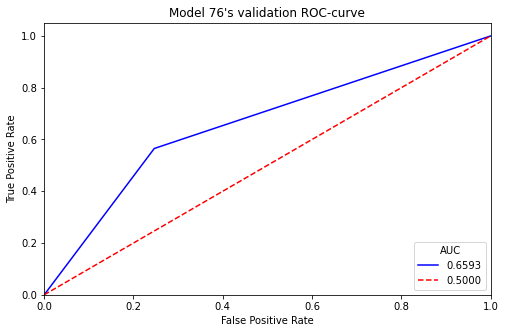

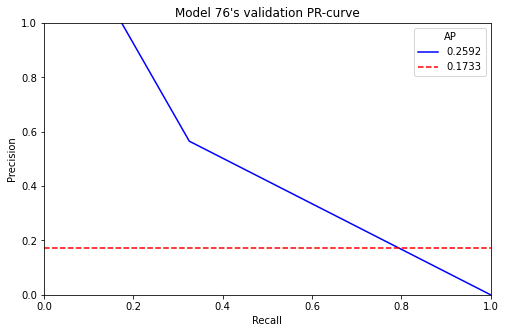

In [852]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.7553816  0.2446184 ]
 [0.45794393 0.54205607]]


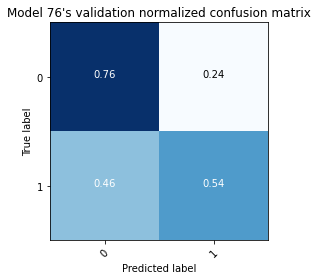

Normalized confusion matrix
[[0.75342466 0.24657534]
 [0.43478261 0.56521739]]


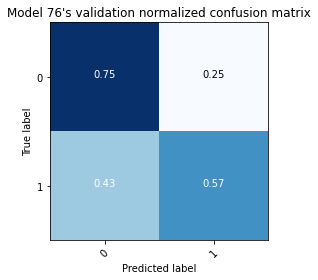

In [854]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

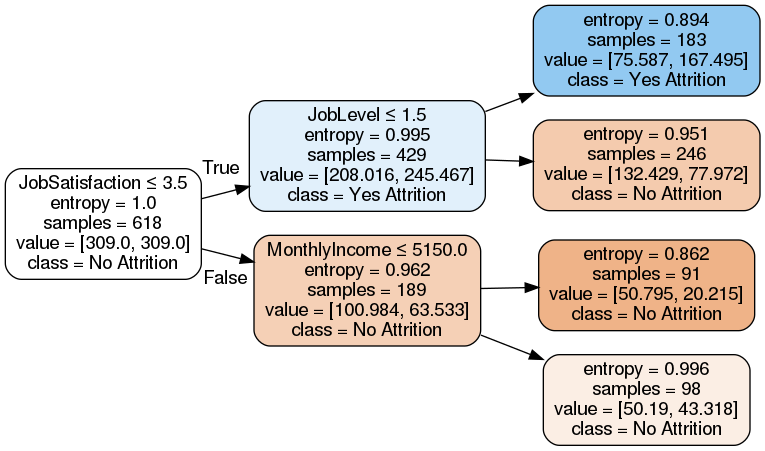

In [855]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

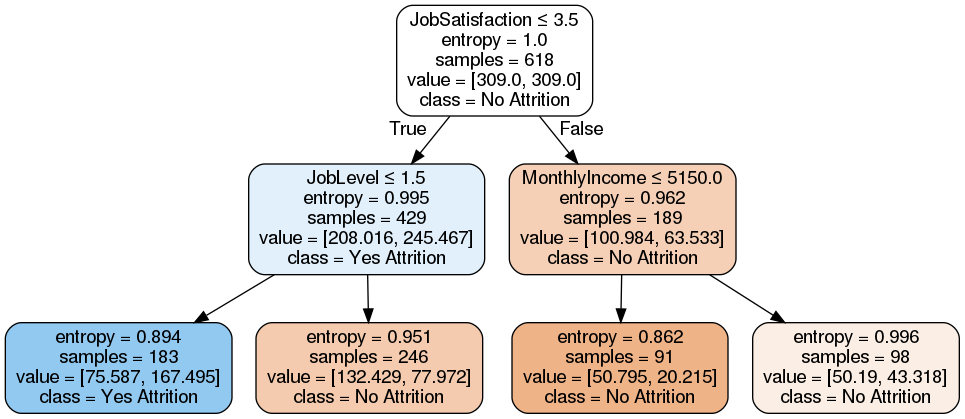

In [856]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [857]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 22)
(883,)


In [858]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 22)
(219,)


In [859]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7304643261608154
Train Precision 0.7887118209574681
Train Recall 0.7304643261608154
Train F1-score 0.752553356412043
Train F2-score 0.7372833896585992
Train roc_auc: 0.648424209866595
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       730
           1       0.33      0.52      0.40       153

    accuracy                           0.73       883
   macro avg       0.61      0.65      0.61       883
weighted avg       0.79      0.73      0.75       883



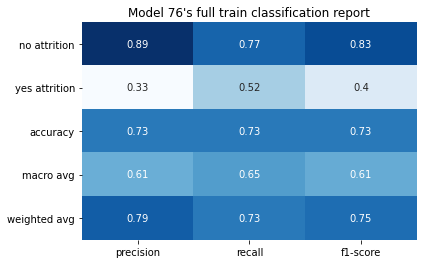

Confusion matrix, without normalization
[[565 165]
 [ 73  80]]


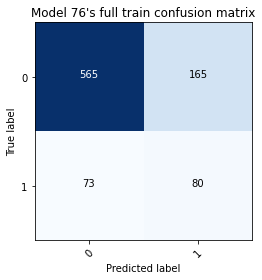

Validation roc_auc: 0.655087440381558
Validation precision_recall_ap: 0.23184156697452427

Test Accuracy 0.7214611872146118
Validation Precision 0.8078492283971735
Validation Recall 0.7214611872146118
Validation F1-score 0.7523352488802847
Validation F2-score 0.7300893253691093
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       185
           1       0.29      0.56      0.38        34

    accuracy                           0.72       219
   macro avg       0.60      0.66      0.60       219
weighted avg       0.81      0.72      0.75       219



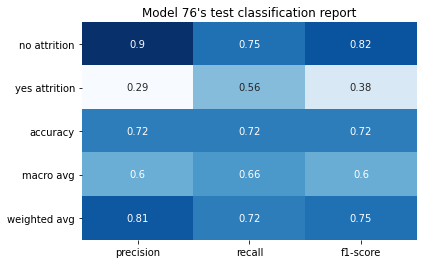

Confusion matrix, without normalization
[[139  46]
 [ 15  19]]


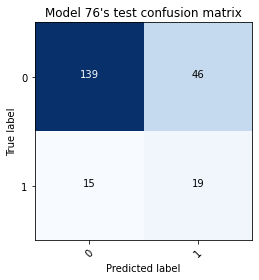

In [882]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

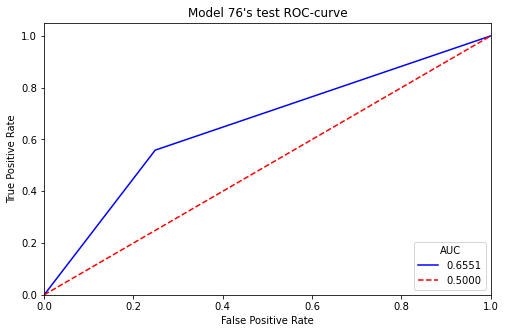

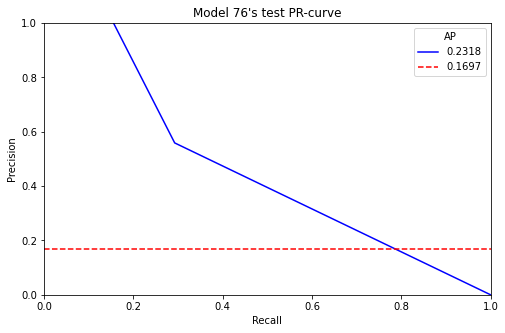

In [883]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.47712418 0.52287582]]


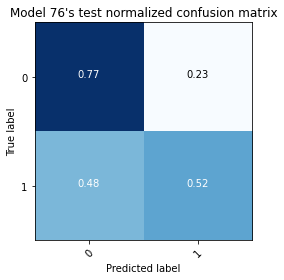

Normalized confusion matrix
[[0.75135135 0.24864865]
 [0.44117647 0.55882353]]


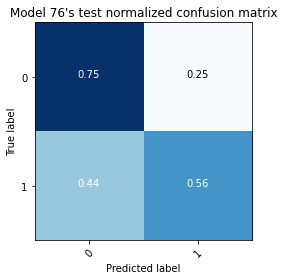

In [884]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [885]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.000, AP=0.15525 


Train Accuracy 0.7576443941109853
Train Precision 0.7970966694622547
Train Recall 0.7576443941109853
Train F1-score 0.7734064256366731
Train F2-score 0.7628432470284212
Train roc_auc: 0.6622795236816188
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       730
           1       0.36      0.52      0.42       153

    accuracy                           0.76       883
   macro avg       0.62      0.66      0.64       883
weighted avg       0.80      0.76      0.77       883



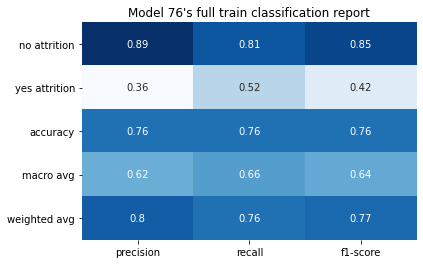

Confusion matrix, without normalization
[[590 140]
 [ 74  79]]


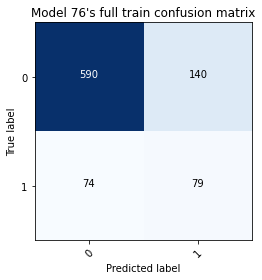

Validation roc_auc: 0.6631955484896661
Validation precision_recall_ap: 0.23974552260144005

Test Accuracy 0.7351598173515982
Validation Precision 0.8116173315207346
Validation Recall 0.7351598173515982
Validation F1-score 0.7629409330022164
Validation F2-score 0.7431309783900614
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       185
           1       0.31      0.56      0.40        34

    accuracy                           0.74       219
   macro avg       0.61      0.66      0.61       219
weighted avg       0.81      0.74      0.76       219



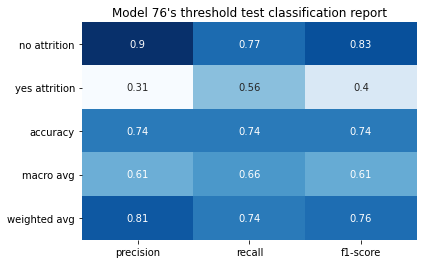

Confusion matrix, without normalization
[[142  43]
 [ 15  19]]


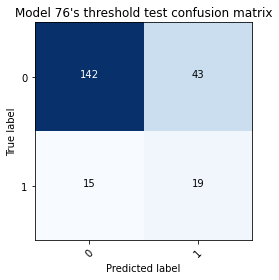

In [940]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

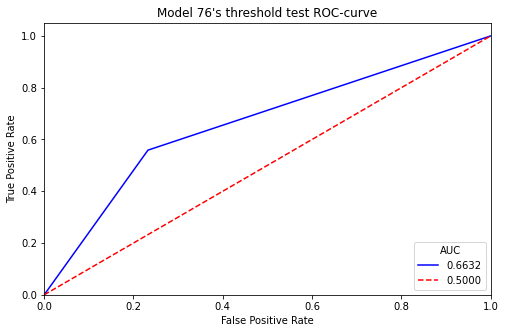

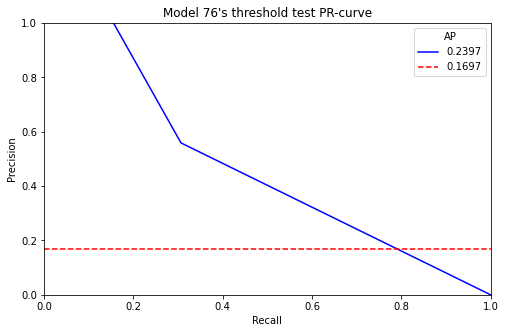

In [941]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.80821918 0.19178082]
 [0.48366013 0.51633987]]


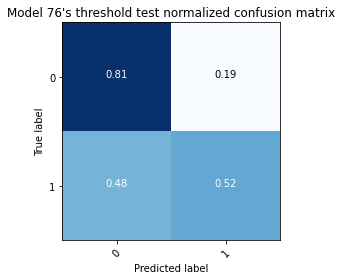

Normalized confusion matrix
[[0.76756757 0.23243243]
 [0.44117647 0.55882353]]


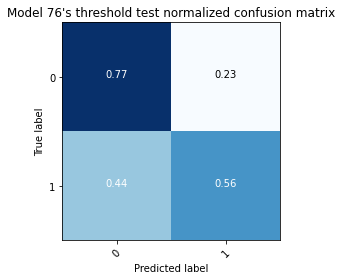

In [942]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h1> Numerical_Disctetized_Recall_no_satisfactions </h1>

In [953]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Discretized_Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [954]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [955]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [956]:
del df_cleaned["EnvironmentSatisfaction"]
del df_cleaned["JobInvolvement"]
del df_cleaned["JobSatisfaction"]
del df_cleaned["RelationshipSatisfaction"]
del df_cleaned["WorkLifeBalance"]
df_cleaned.shape

(883, 19)

In [957]:
del df_ts["EnvironmentSatisfaction"]
del df_ts["JobInvolvement"]
del df_ts["JobSatisfaction"]
del df_ts["RelationshipSatisfaction"]
del df_ts["WorkLifeBalance"]
df_ts.shape

(219, 19)

In [980]:
criterion='gini'
max_features='auto'
max_depth=6
min_samples_split=60
min_samples_leaf=2
class_weight='balanced'
model_name = 0
cmap = plt.cm.Oranges
color = "orange"

<h6> Train again model on Validation Set </h6>

In [981]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 18)
(883,)


In [982]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [983]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7038834951456311
Train Precision 0.84663898902107
Train Recall 0.7038834951456311
Train F1-score 0.7392993572331441
Train F2-score 0.7070207258345919
Train roc_auc: 0.754439709567094
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       511
           1       0.35      0.83      0.49       107

    accuracy                           0.70       618
   macro avg       0.65      0.75      0.64       618
weighted avg       0.85      0.70      0.74       618



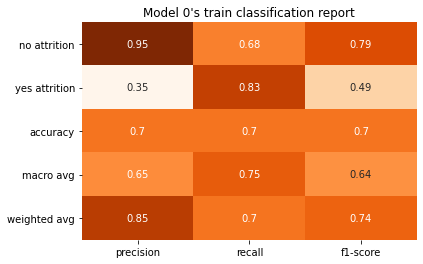

Confusion matrix, without normalization
[[346 165]
 [ 18  89]]


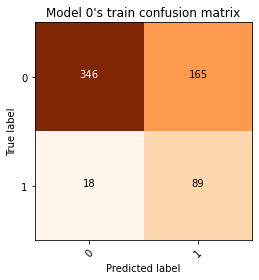

Validation roc_auc: 0.7229005360333532
Validation precision_recall_ap: 0.29757130687196315

Test Accuracy 0.6981132075471698
Validation Precision 0.8283699483453381
Validation Recall 0.6981132075471698
Validation F1-score 0.7334392585236678
Validation F2-score 0.7031734876649907
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       219
           1       0.34      0.76      0.47        46

    accuracy                           0.70       265
   macro avg       0.63      0.72      0.63       265
weighted avg       0.83      0.70      0.73       265



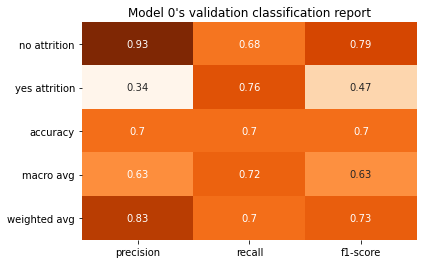

Confusion matrix, without normalization
[[150  69]
 [ 11  35]]


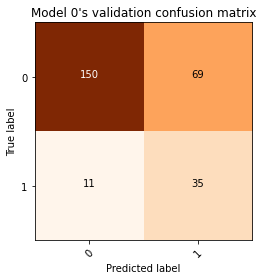

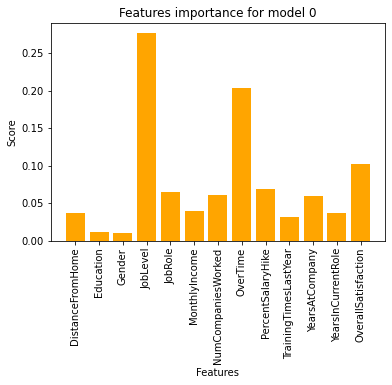

In [986]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

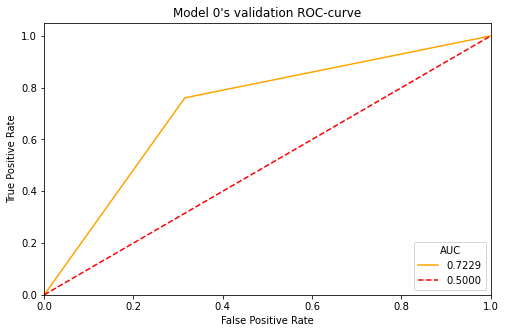

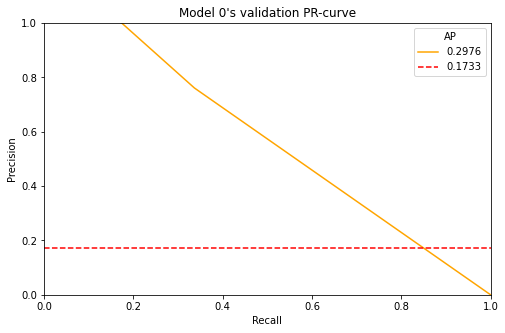

In [987]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.67710372 0.32289628]
 [0.1682243  0.8317757 ]]


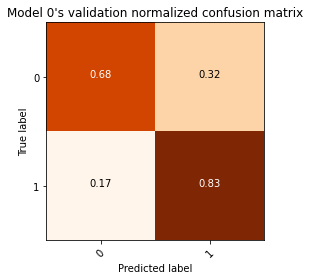

Normalized confusion matrix
[[0.68493151 0.31506849]
 [0.23913043 0.76086957]]


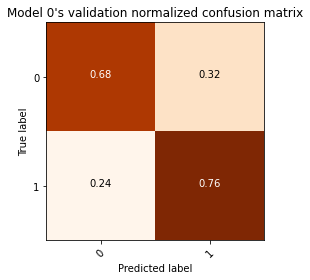

In [988]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

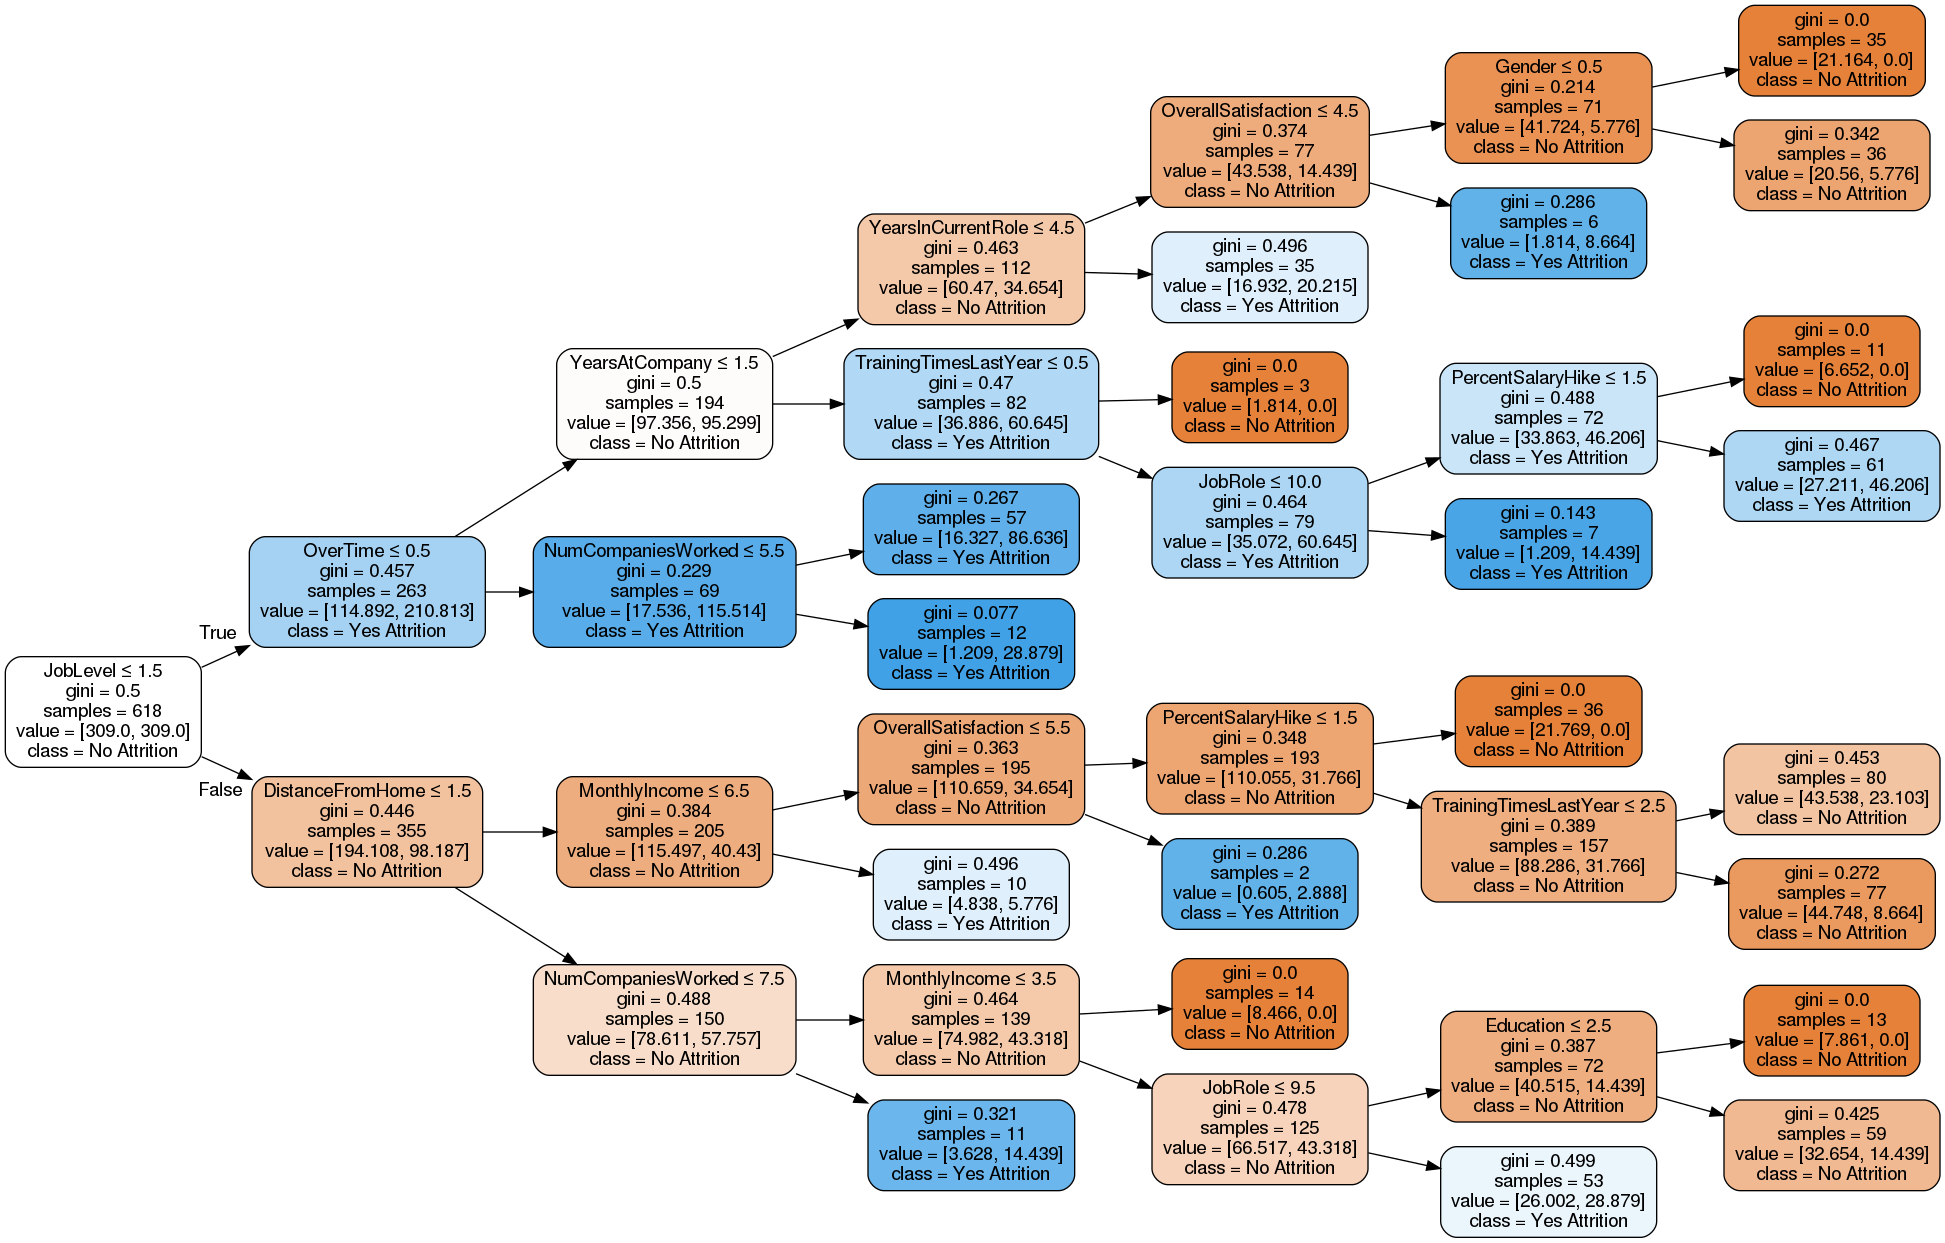

In [989]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

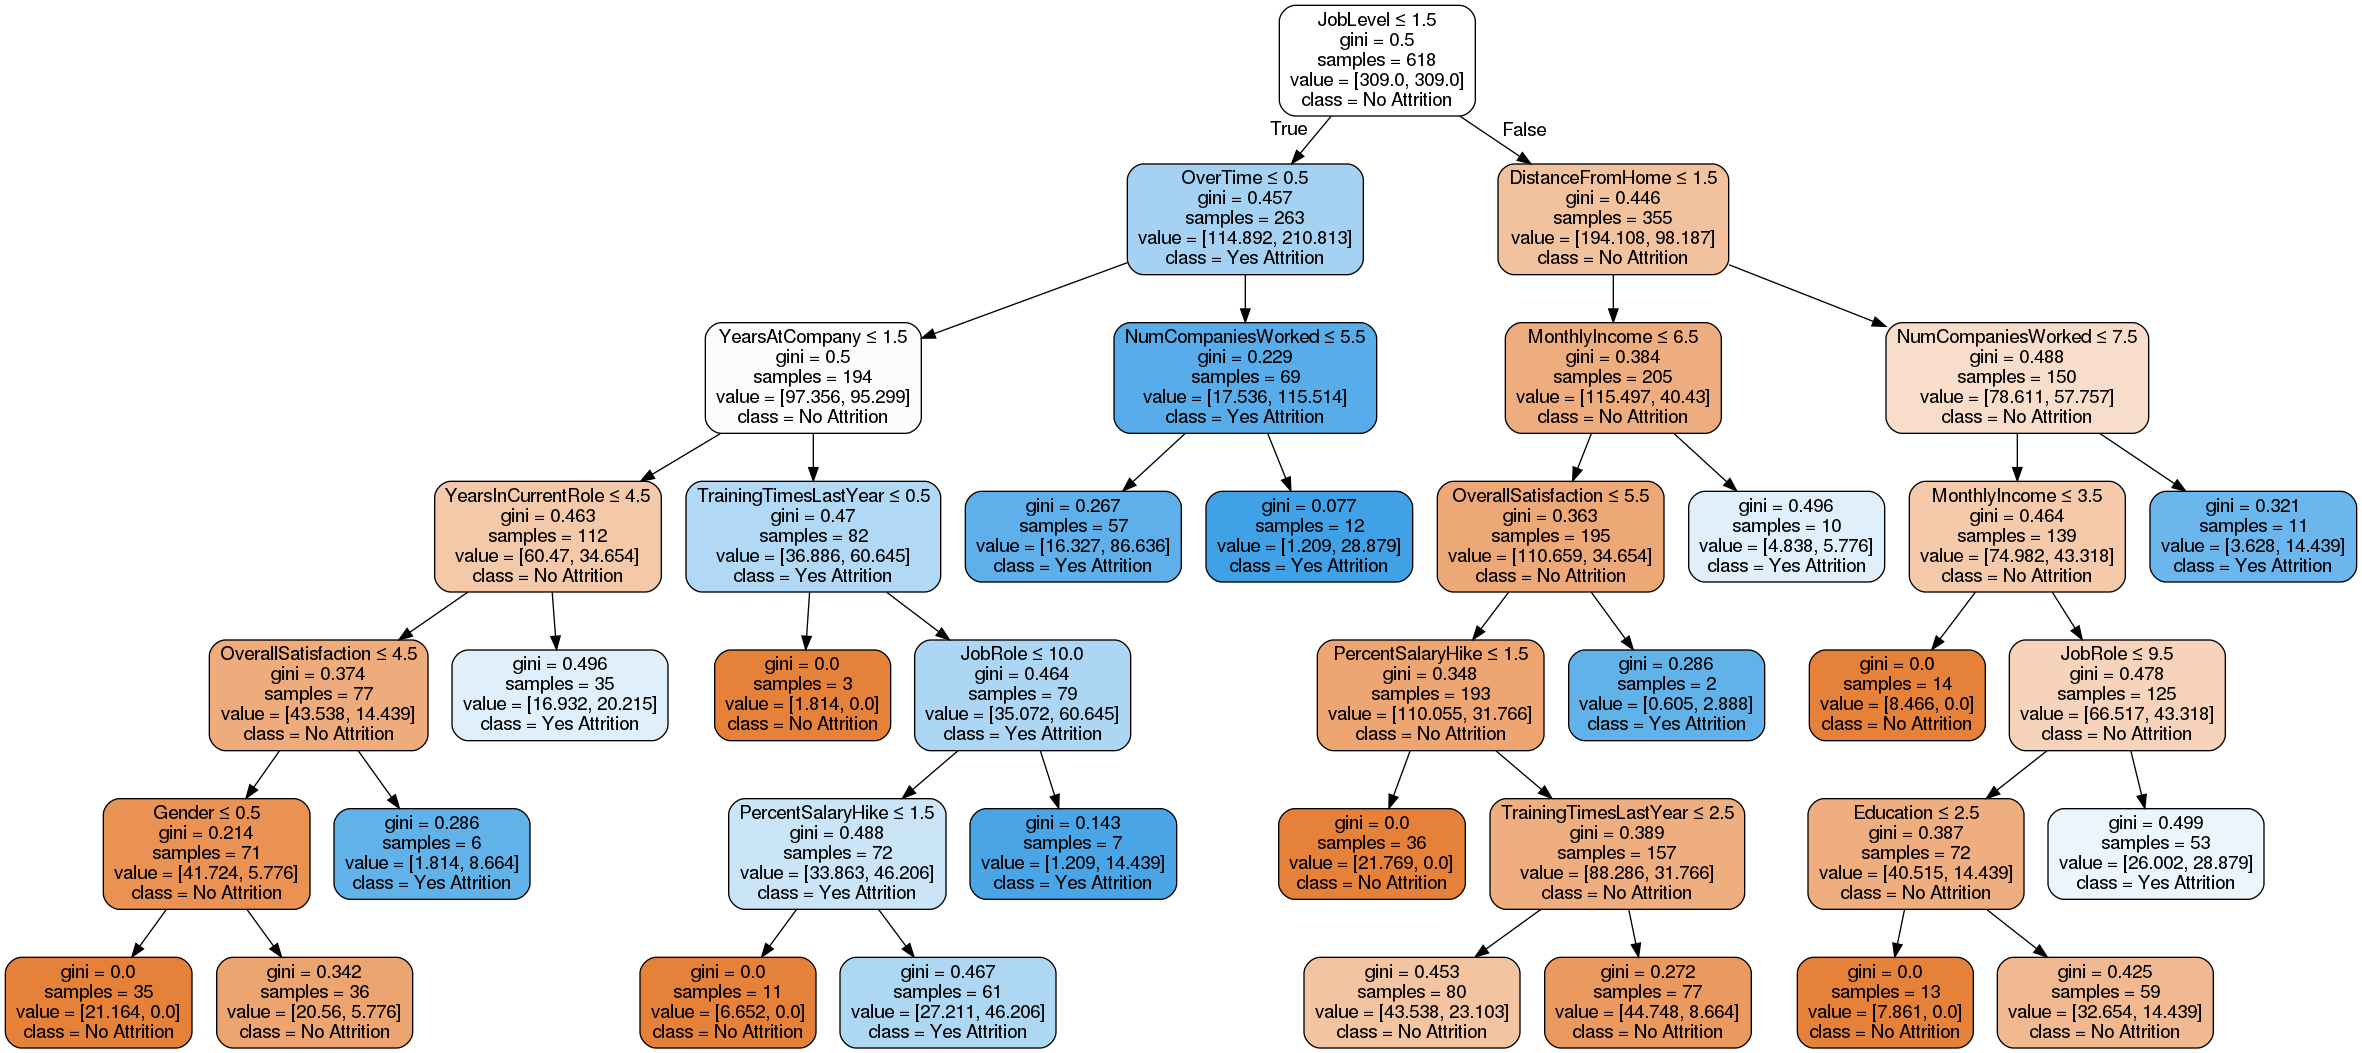

In [990]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [991]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 18)
(883,)


In [992]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 18)
(219,)


In [993]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7633069082672707
Train Precision 0.8411356966279624
Train Recall 0.7633069082672707
Train F1-score 0.7869326795004077
Train F2-score 0.76811796919567
Train roc_auc: 0.7535276210940998
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       730
           1       0.40      0.74      0.52       153

    accuracy                           0.76       883
   macro avg       0.67      0.75      0.68       883
weighted avg       0.84      0.76      0.79       883



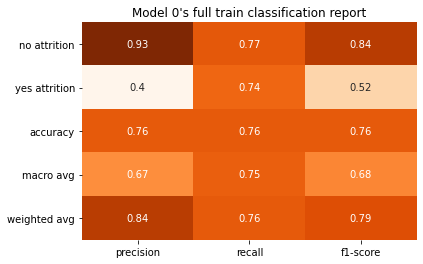

Confusion matrix, without normalization
[[561 169]
 [ 40 113]]


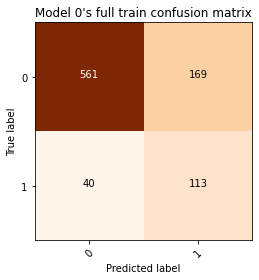

Validation roc_auc: 0.7259141494435613
Validation precision_recall_ap: 0.2842702197606807

Test Accuracy 0.7397260273972602
Validation Precision 0.8401504919930542
Validation Recall 0.7397260273972602
Validation F1-score 0.7711241574255273
Validation F2-score 0.7463933558334989
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       185
           1       0.34      0.71      0.46        34

    accuracy                           0.74       219
   macro avg       0.64      0.73      0.64       219
weighted avg       0.84      0.74      0.77       219



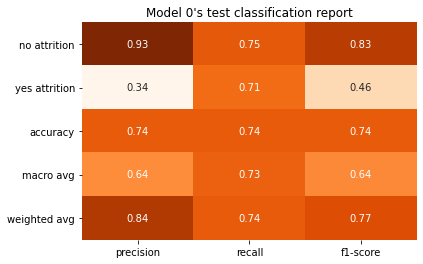

Confusion matrix, without normalization
[[138  47]
 [ 10  24]]


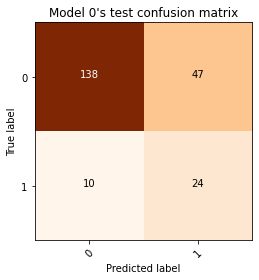

In [994]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

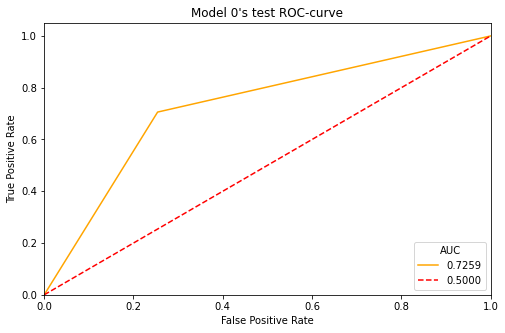

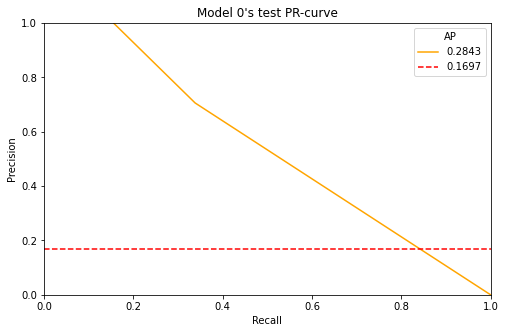

In [995]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.76849315 0.23150685]
 [0.26143791 0.73856209]]


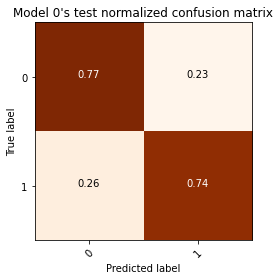

Normalized confusion matrix
[[0.74594595 0.25405405]
 [0.29411765 0.70588235]]


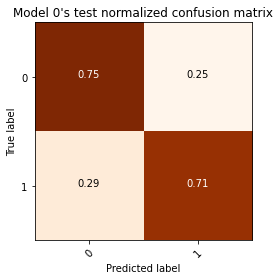

In [996]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [997]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.443, AP=0.22509 


Train Accuracy 0.7123442808607021
Train Precision 0.8403637041903337
Train Recall 0.7123442808607021
Train F1-score 0.7460176347791787
Train F2-score 0.7165049681898487
Train roc_auc: 0.7459530844301191
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       730
           1       0.35      0.80      0.49       153

    accuracy                           0.71       883
   macro avg       0.65      0.75      0.64       883
weighted avg       0.84      0.71      0.75       883



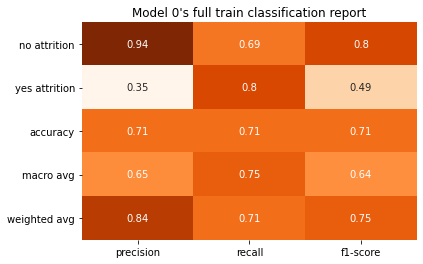

Confusion matrix, without normalization
[[507 223]
 [ 31 122]]


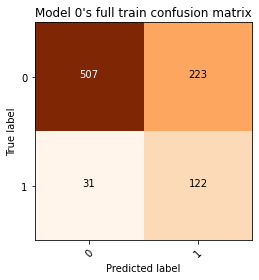

Validation roc_auc: 0.7337042925278218
Validation precision_recall_ap: 0.2819908277872285

Test Accuracy 0.7123287671232876
Validation Precision 0.8456116098892883
Validation Recall 0.7123287671232876
Validation F1-score 0.7501841174073466
Validation F2-score 0.718391147564227
              precision    recall  f1-score   support

           0       0.94      0.70      0.80       185
           1       0.32      0.76      0.45        34

    accuracy                           0.71       219
   macro avg       0.63      0.73      0.63       219
weighted avg       0.85      0.71      0.75       219



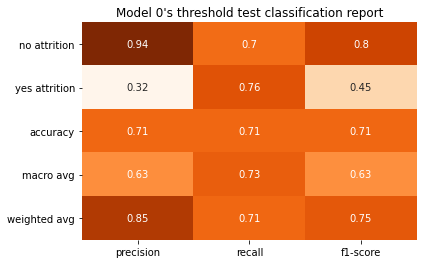

Confusion matrix, without normalization
[[130  55]
 [  8  26]]


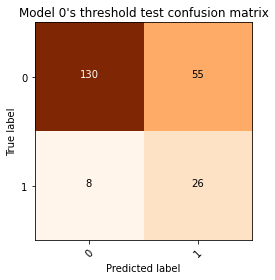

In [1003]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

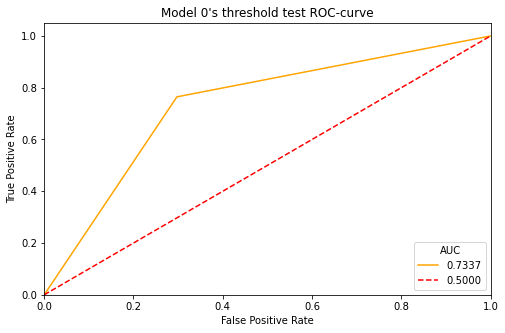

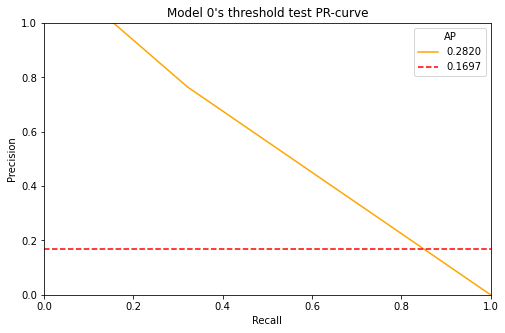

In [1004]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.69452055 0.30547945]
 [0.20261438 0.79738562]]


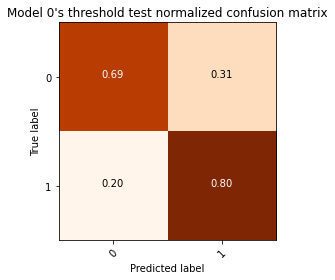

Normalized confusion matrix
[[0.7027027  0.2972973 ]
 [0.23529412 0.76470588]]


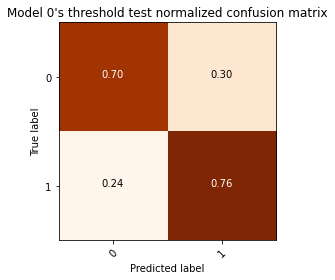

In [1005]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h1> Numerical_Disctetized_Recall </h1>

In [1125]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Discretized_Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [1126]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [1127]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [1128]:
del df_cleaned["OverallSatisfaction"]
df_cleaned.shape

(883, 23)

In [1129]:
del df_ts["OverallSatisfaction"]
df_ts.shape

(219, 23)

In [1130]:
criterion='gini'
max_features='sqrt'
max_depth=15
min_samples_split=90
min_samples_leaf=10
class_weight='balanced'
model_name = 31
cmap = plt.cm.spring_r
color = "fuchsia"

<h6> Train again model on Validation Set </h6>

In [1131]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 22)
(883,)


In [1132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [1133]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7346278317152104
Train Precision 0.8101378300236184
Train Recall 0.7346278317152104
Train F1-score 0.7601469423586439
Train F2-score 0.7412034358559499
Train roc_auc: 0.6917533880790825
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       511
           1       0.35      0.63      0.45       107

    accuracy                           0.73       618
   macro avg       0.63      0.69      0.64       618
weighted avg       0.81      0.73      0.76       618



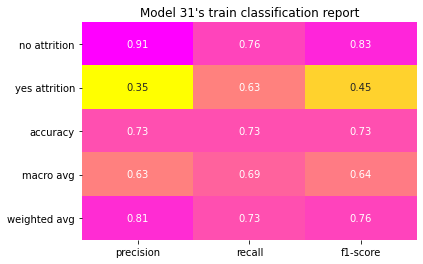

Confusion matrix, without normalization
[[387 124]
 [ 40  67]]


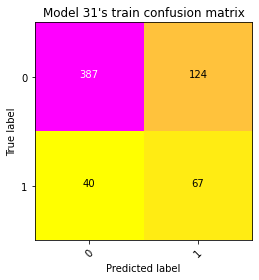

Validation roc_auc: 0.6742108397855867
Validation precision_recall_ap: 0.26843603725329346

Test Accuracy 0.7169811320754716
Validation Precision 0.8009544950055494
Validation Recall 0.7169811320754716
Validation F1-score 0.745278145673849
Validation F2-score 0.7242395282700046
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       219
           1       0.33      0.61      0.43        46

    accuracy                           0.72       265
   macro avg       0.61      0.67      0.62       265
weighted avg       0.80      0.72      0.75       265



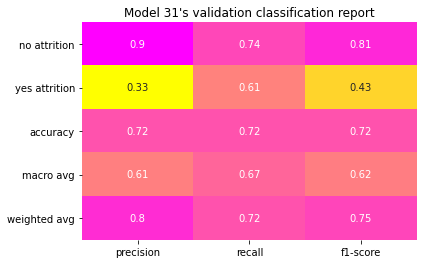

Confusion matrix, without normalization
[[162  57]
 [ 18  28]]


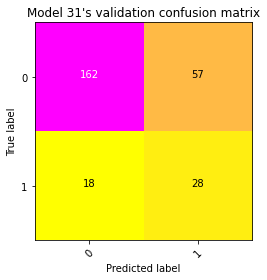

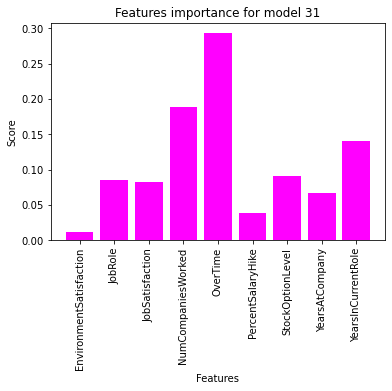

In [1152]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

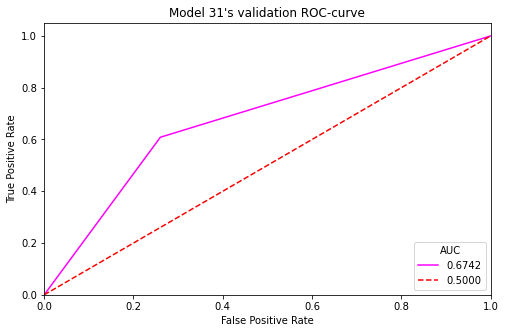

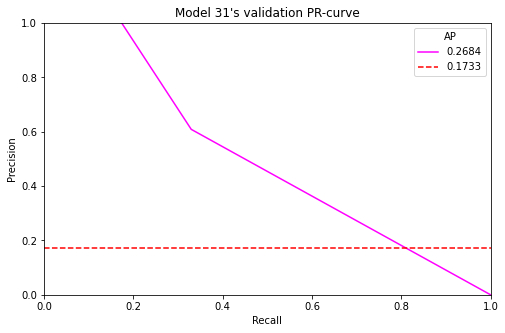

In [1153]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.75733855 0.24266145]
 [0.37383178 0.62616822]]


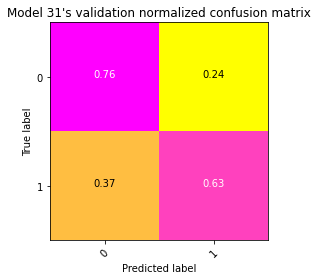

Normalized confusion matrix
[[0.73972603 0.26027397]
 [0.39130435 0.60869565]]


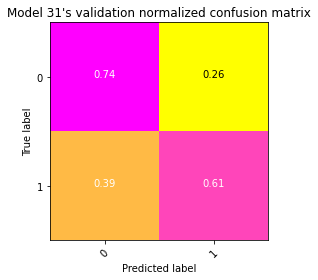

In [1154]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

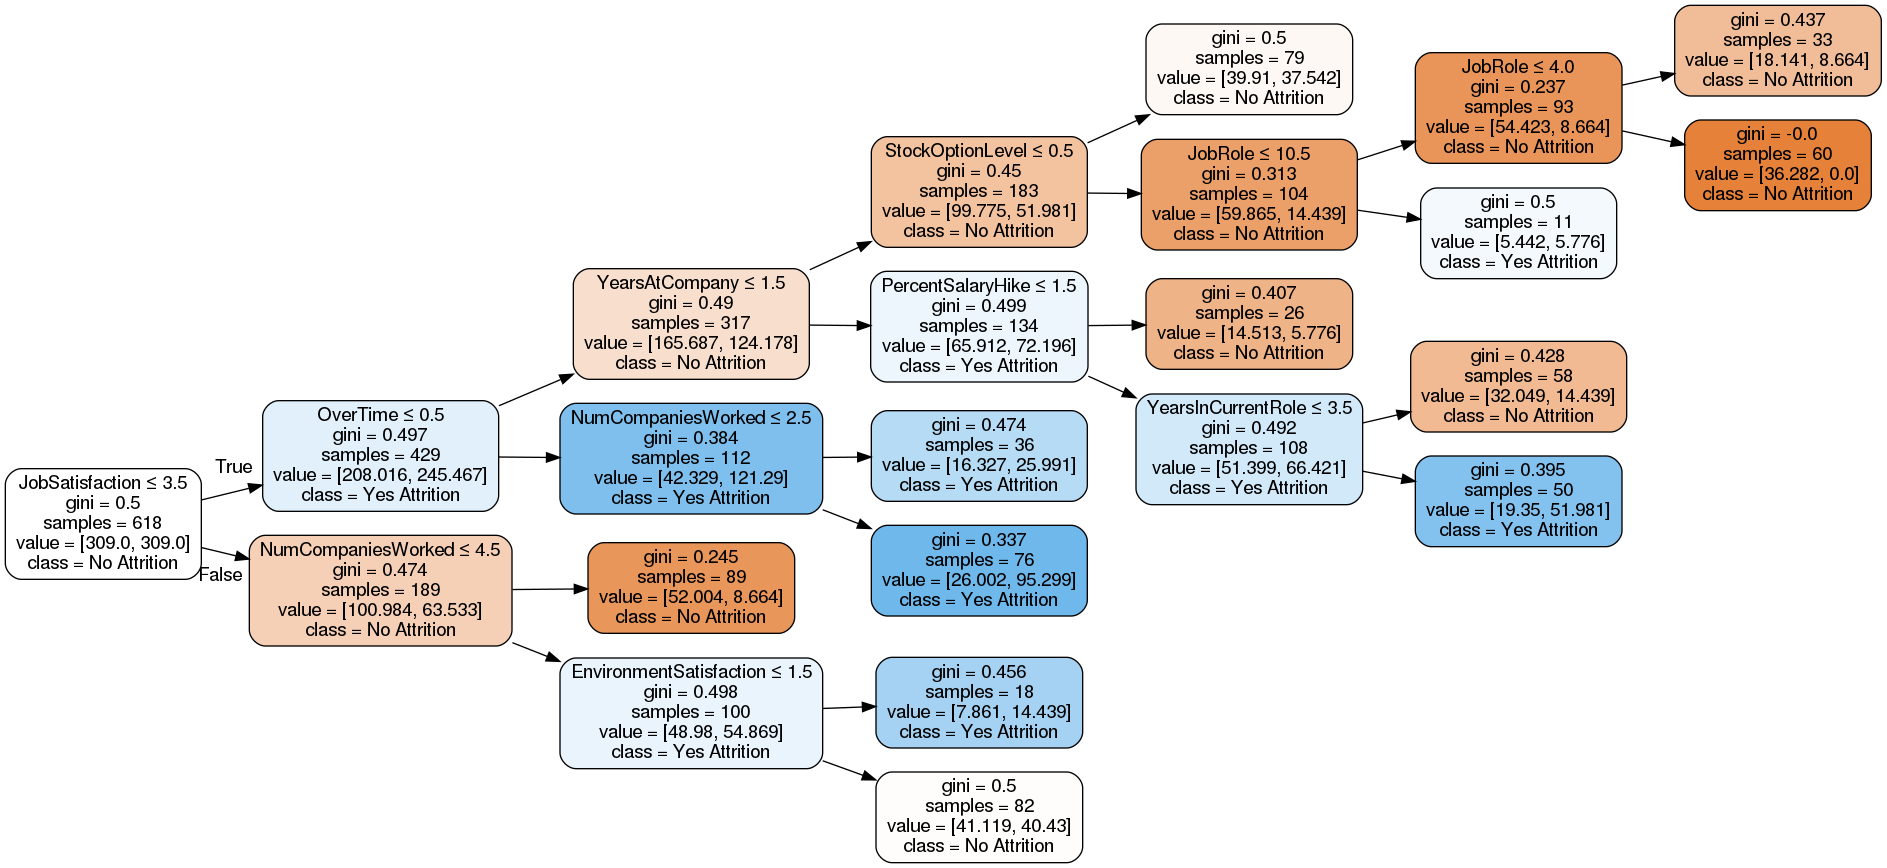

In [1155]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

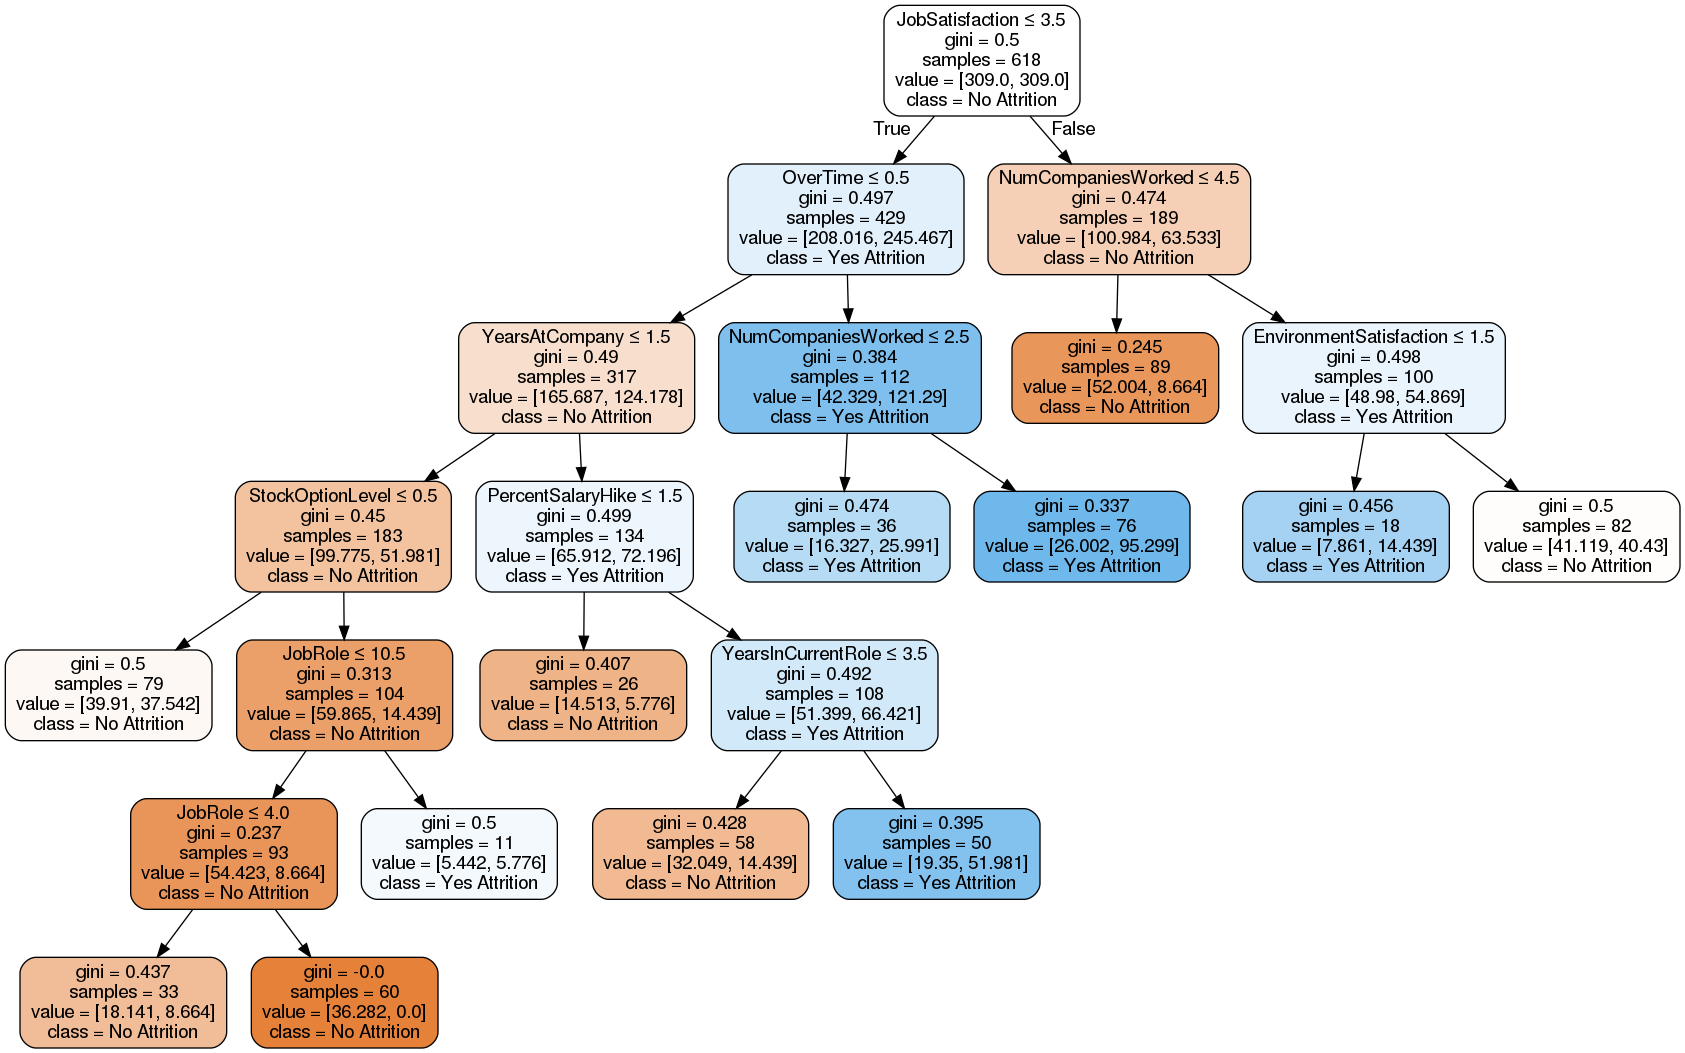

In [1156]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [1157]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 22)
(883,)


In [1158]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 22)
(219,)


In [1159]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7893544733861835
Train Precision 0.8348552660191737
Train Recall 0.7893544733861835
Train F1-score 0.8053460155982171
Train F2-score 0.7937930569369919
Train roc_auc: 0.7382845375593159
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       730
           1       0.43      0.66      0.52       153

    accuracy                           0.79       883
   macro avg       0.67      0.74      0.69       883
weighted avg       0.83      0.79      0.81       883



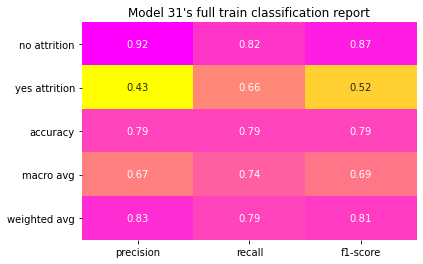

Confusion matrix, without normalization
[[596 134]
 [ 52 101]]


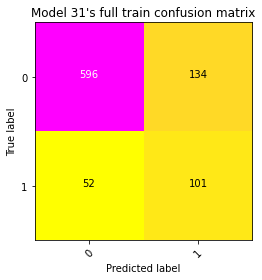

Validation roc_auc: 0.7274244833068364
Validation precision_recall_ap: 0.2933349281493419

Test Accuracy 0.7625570776255708
Validation Precision 0.8405923184563264
Validation Recall 0.7625570776255708
Validation F1-score 0.7884249590247059
Validation F2-score 0.7688439070431876
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       185
           1       0.36      0.68      0.47        34

    accuracy                           0.76       219
   macro avg       0.64      0.73      0.66       219
weighted avg       0.84      0.76      0.79       219



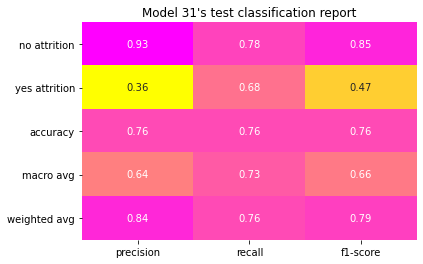

Confusion matrix, without normalization
[[144  41]
 [ 11  23]]


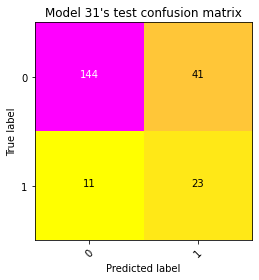

In [1173]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

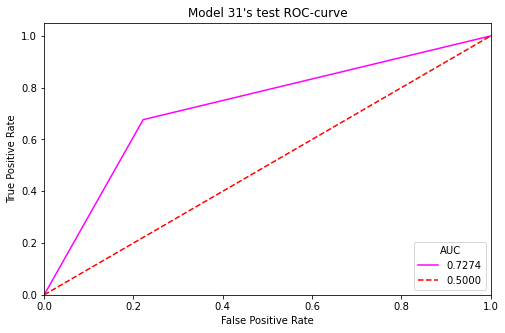

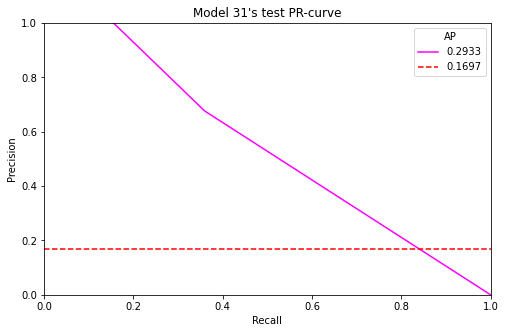

In [1174]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.81643836 0.18356164]
 [0.33986928 0.66013072]]


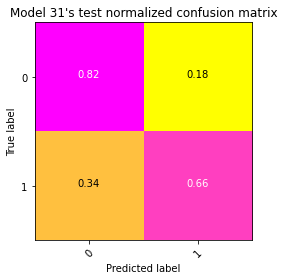

Normalized confusion matrix
[[0.77837838 0.22162162]
 [0.32352941 0.67647059]]


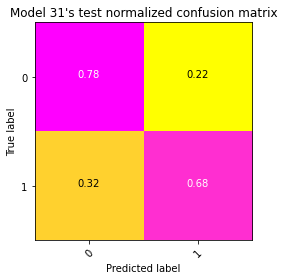

In [1175]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [1176]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.629, AP=0.25331 


Train Accuracy 0.7327293318233296
Train Precision 0.8338741495056016
Train Recall 0.7327293318233296
Train F1-score 0.7620175832777099
Train F2-score 0.7379407016211039
Train roc_auc: 0.737617512758528
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       730
           1       0.37      0.75      0.49       153

    accuracy                           0.73       883
   macro avg       0.65      0.74      0.66       883
weighted avg       0.83      0.73      0.76       883



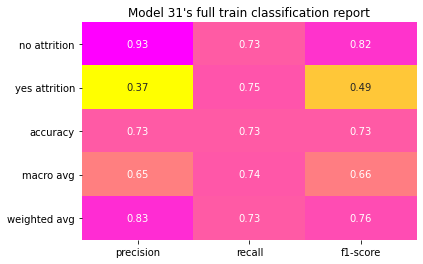

Confusion matrix, without normalization
[[533 197]
 [ 39 114]]


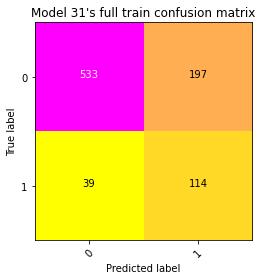

Validation roc_auc: 0.7340222575516694
Validation precision_recall_ap: 0.29479704855350686

Test Accuracy 0.7534246575342466
Validation Precision 0.8435997459856663
Validation Recall 0.7534246575342466
Validation F1-score 0.7820450097847359
Validation F2-score 0.7597281798195039
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       185
           1       0.35      0.71      0.47        34

    accuracy                           0.75       219
   macro avg       0.64      0.73      0.65       219
weighted avg       0.84      0.75      0.78       219



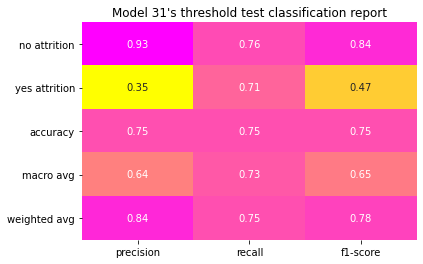

Confusion matrix, without normalization
[[141  44]
 [ 10  24]]


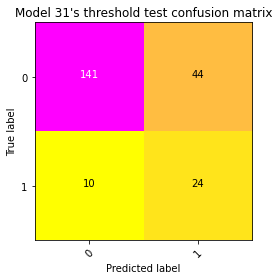

In [1406]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

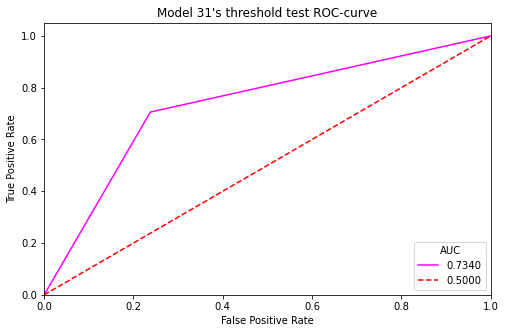

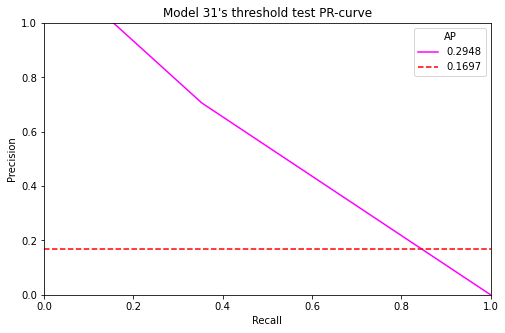

In [1407]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.73013699 0.26986301]
 [0.25490196 0.74509804]]


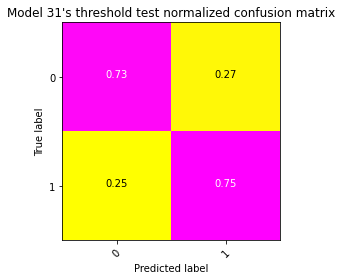

Normalized confusion matrix
[[0.76216216 0.23783784]
 [0.29411765 0.70588235]]


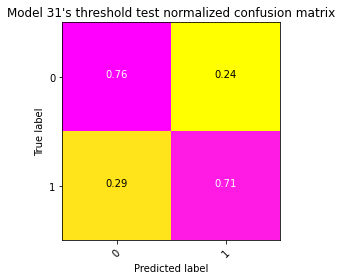

In [1408]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h2>Validarion curves</h2>

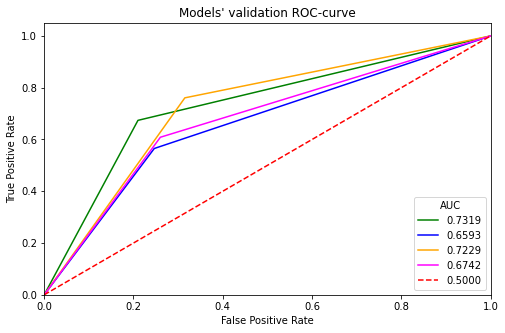

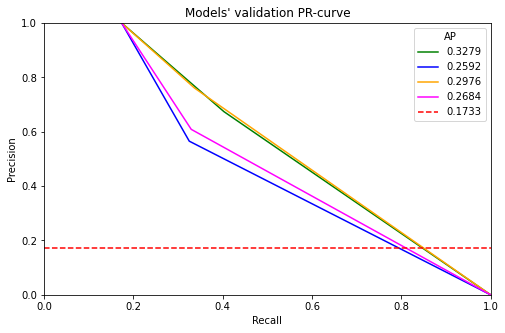

In [1409]:
draw_multiple_roc_and_ap_curves("validation")

<h2> Test curves </h2>

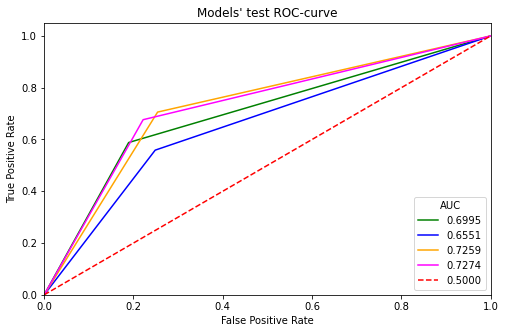

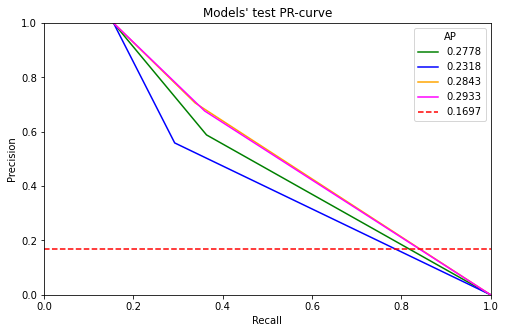

In [1410]:
draw_multiple_roc_and_ap_curves("test")

<h2> Threshold test curves </h2>

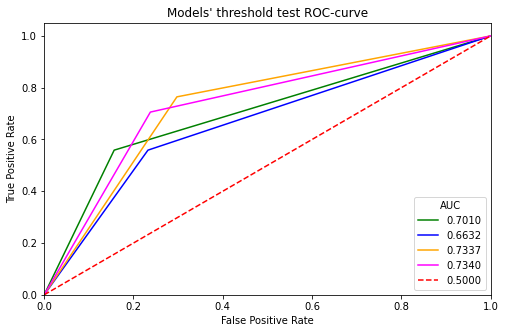

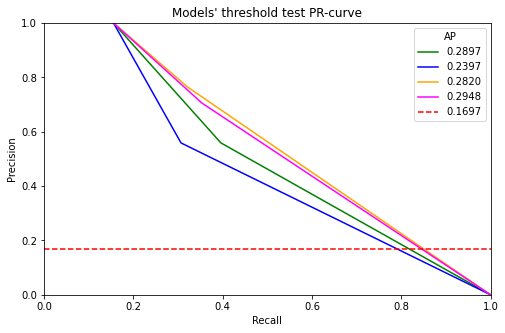

In [1411]:
draw_multiple_roc_and_ap_curves("threshold test")